<a href="https://colab.research.google.com/github/bmmcc4/Pytorch_final/blob/main/PyTorch_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PyTorch - NLP From Scratch: Generating names with a Character-Level RNN**

**Objective:** Create and train an RNN that will be able to generate names from a language of origin. 

# Grab data from GitHub Repo

Data is in the form of multiple plain text files. The plain text files contain names from different languages of origin from around the world. There are 18 different plain text files, so, 18 different languages of origin. Each plain text file contains a new name on each line. Each plain text files has a varing number of names. Some contain upwards of 2000 whereas others are around 500. Data was provided by PyTorch, stored on GitHub for ease of access.

In [77]:
!ls

data  Pytorch_final  sample_data


In [78]:
!cd data

In [79]:
# Clone into GitHub Repo with Text name data
!git clone https://github.com/bmmcc4/Pytorch_final.git

fatal: destination path 'Pytorch_final' already exists and is not an empty directory.


# Prepare the Data

Loop through plain text files in specified folder. Split the text on new lines in file into an array. Convert Unicode into ASCII. Save categories into an arr. Save text in each category into a dict with the category as the key.

In [148]:
# imports
from __future__ import unicode_literals, print_function, division
from io import open # open and read files in directory
import glob # used to find pathnames on a computer
import os
import unicodedata 
import string # Collection of string constants
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
from IPython.display import Image

In [106]:
all_letters = string.ascii_letters + " .,;'-" 
# string of all lowercase and uppercase ascii characters (A-Z), it is a constant so it will not change. Common characters are also added to string.

n_letters = len(all_letters) + 1 
# Plus End of string marker, use len function to calculate length

In [107]:
def findFiles(path): return glob.glob(path)
# define function "findFiles", takes in a file path as an argument
# function returns the file path that matches the specified pattern
# function will allow us to loop through each file in the specified pattern or directory

In [108]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )
# Define function to take in a unicode string as an argument and return the Ascii (normalized) string
# Its application in this example is to remove written accents from names
# Using list comprehension, loop through the letters passed into the function, return c
# Mn means nonspacing_mark (symbol with letter)
# confirm c is also in all_letters

This transformation function is needed because of possible errors that can be caused by irregular letters. ASCII will have simpler characters, and reduce error if everything is normalized.

In [109]:
# Read a file and split into lines
def readLines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]
# Define function to read lines of file, takes in filename as argument
# use imported open function to open file for reading
# Convert and return each line in text file to Ascii, stripped of any surronding spaces

In [110]:
# Build the category_line dictionary, a list of lines per category
category_lines = {} # Create empty dict
all_categories = [] # Create empty arr
for filename in findFiles('Pytorch_final/*.txt'): # loop through files in directory
  category = os.path.splitext(os.path.basename(filename))[0] # isolate the filename from file ext. then save filename into category
  all_categories.append(category) # append each category to all_categories arr that was created outside for loop
  lines = readLines(filename) # call readLines function for each filename
  category_lines[category] = lines # category_lines at specified category will equal lines

In [111]:
n_categories = len(all_categories) # get lengh of the all_categories arr

In [112]:
# Exception handling
if n_categories == 0:
  raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

In [113]:
# Outputs
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['English', 'Italian', 'Portuguese', 'Russian', 'Czech', 'Polish', 'French', 'Vietnamese', 'German', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Greek', 'Chinese', 'Japanese', 'Korean', 'Dutch']
O'Neal


# Creating the Network

The state of the network is held in the graph (Autograd) and not in the layers, simply create an nn.Linear and reuse it over and over again for the recurrence

At a high level, the model will utilize a few linear layers. We will imput a category, then take an input letter one at a time, then predict the next letter which will be used as the next input letter. This process of finding letters will repeat until an EOS token is found. It is known as a "language model."

The model takes in 3 different arguments, category, input, and hidden. Input and hidden are needed for any RNN model in this form. Category is needed to represent the language of origin of the name. 

Per standard convention, the inputs will be stored in tensors. The category, input, and hidden will be concatenated together. 

Two linear layers will be created, each one to operate on an input and hidden state. Output and hidden will then be concatinated into out_combined.

Another linear layer is created (o2o) to give the model more to work with?

A dropout layer is then created which will randomly zero parts of its input with a given probability of 0.1 (where did this come from?). We are doing this to help prevent overfitting improve regularization. It is implented near the output to drive sampling variety.

A final LogSoftMax layer is added which will help standardize the inputs by making the values proportional to the relative scale of each value in the tensor.

The output is then pushed back as an input, therefore, making the network recurrent. 

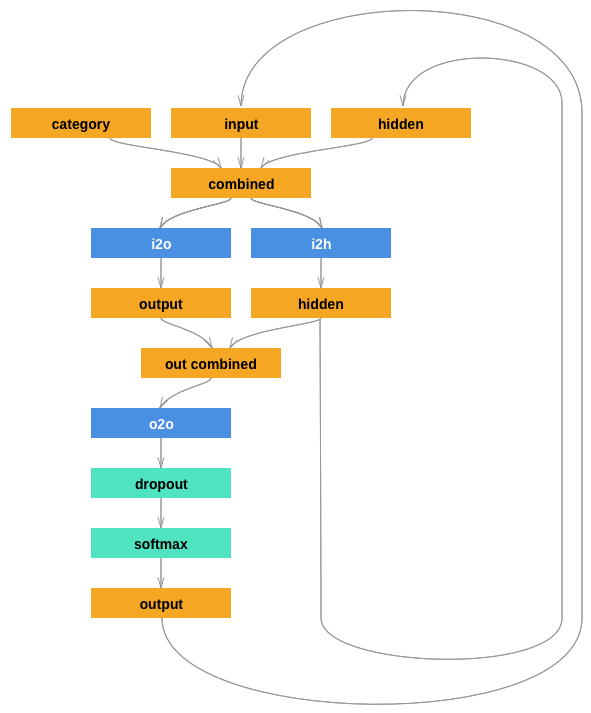

In [150]:
Image('/content/RNN.png')

In [141]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training

**Preparing for training**

In [116]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [126]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories) # pass all_categories arr to randomChoice func
    line = randomChoice(category_lines[category]) # save a random name from a line in determined random category
    return category, line

The inputs of the network for each letter in a training word (timestep) are (category, current letter, hidden state). The outputs will be (next letter, next hidden state). For each training set, a category, a set of input letter, and a set of output letter will be needed.

We will need to create a category tensor that is the size of the number of categories. The category tensor will be a one-hot tensor meaning that a single value will be high (1) while the rest will be low (0). The category tensor is fed to the network at every timestep.

In [127]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)  # get index of the specified category
    tensor = torch.zeros(1, n_categories) # create a tensor of zeros that is the length of the number of categories
    tensor[0][li] = 1 # make the value of the tensor at the category index equal to 1
    return tensor # return one-hot tensor

In [128]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters) # create a matrix of zeros that is length of the number of characters in the random name long, 1 column, and each item is n_letters long
  for li in range(len(line)): # loop through letters in line item
    letter = line[li] # find line index of letter
    tensor[li][0][all_letters.find(letter)] = 1 # Find letter in all_letters, assign that value to one
  return tensor # return one-hot matrix

In [129]:
# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  # find next letter index, thats why we start range at 1
  letter_indexes.append(n_letters - 1) # EOS
  return torch.LongTensor(letter_indexes)

In [130]:
# make random training example from category, input, and target tensors from a random category and line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

**Training the Network**

Loss needs to be calculated at every step because a prediction is being made at every step. The PyTorch Autograd will allow to easily sum the loses and backpropagate through. Autograd will catulate and store the gradients for each model parameter in the parameter's grad attribute.

In [131]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward() # Backprop is kicked off here

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate) # add gradients to model parameters

    return output, loss.item() / input_line_tensor.size(0)

In [132]:
# To keep track of how long training takes, a function to display the time in a human readable string is created
def timeSince(since):
  now = time.time() # current time
  s = now = since
  m = math.floor(s / 60) # largest int
  s -= m * 60
  return '%dm %ds' % (m, s)

The training process is simple, call train a bunch of times on randomTrainingExample. To keep tabs on progress the current time and loss is printed every 5000 examples. All_losses will be used later to validate the model has successfully learned.

In [133]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000 # number of epochs, large number of names in training data
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1): # Start loop
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

27263992m 46s (5000 5%) 3.2550
27263992m 46s (10000 10%) 2.5195
27263992m 46s (15000 15%) 2.6188
27263992m 46s (20000 20%) 2.3362
27263992m 46s (25000 25%) 2.5231
27263992m 46s (30000 30%) 3.2493
27263992m 46s (35000 35%) 2.8191
27263992m 46s (40000 40%) 2.6939
27263992m 46s (45000 45%) 2.3437
27263992m 46s (50000 50%) 2.8446
27263992m 46s (55000 55%) 2.5146
27263992m 46s (60000 60%) 1.8118
27263992m 46s (65000 65%) 1.8187
27263992m 46s (70000 70%) 2.8378
27263992m 46s (75000 75%) 1.8895
27263992m 46s (80000 80%) 2.8829
27263992m 46s (85000 85%) 2.1687
27263992m 46s (90000 90%) 2.9199
27263992m 46s (95000 95%) 1.9594
27263992m 46s (100000 100%) 3.4709


**Plotting the Losses**

Using matplotlib to visualize the historical loss, this will in turn be showing the network learning. The graph should model exponential decay as the model learns and loss decreases.

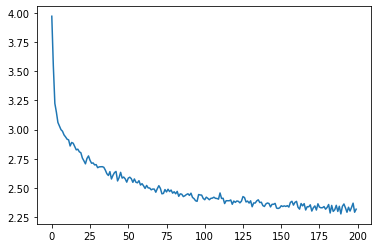

In [135]:
plt.figure()
plt.plot(all_losses)

# Sampling the Network

Network needs a starting letter which will be supplied, the network is then asked what the next letter is, that letter is fed in as the next letter, this process repeats until the EOS token.

PSUEDO CODE:
*   Create tensors for input category, starting letter, and empty hidden state
*   Create a string output_name with the starting letter
*   Up to the maximum output length
      - Feed the current letter to the network
      - Get the next letter from highest output, and next hidden state
      - If the letter is EOS, stop here
      - If a regular letter, add to output_name and conttinue
*   Return final name







In [140]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovako
Uantovan
Santano
Gerteng
Erenger
Ronger
Salla
Pantara
Allan
Chang
Han
Ian


# Conclusion

The RNN model created was able to successfully generate names based on a language of origin and a starting letter. 

The approach to create this utilized the functions found in Autograd to sum the losses at each step and backpropagate them through the model. Therefore, creating a model that can effectively be trained and be accurate. 

Further exercises to improve the model could be taking out the starting letter and using a start of string token during training. This would have the network choose its own starting letter.